### Text Generation RNN
This notebook is a follow up for text generation using a character based RNN. We will be working on the dataset of Shakespeare's writting from Andrej Karpathy.[The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

### Model

* The model is character-based. When training started, the model did not know how to spell an English word, or that words were even a unit of text.

* The structure of the output resembles a play—blocks of text generally begin with a speaker name, in all capital letters similar to the dataset.

* As demonstrated below, the model is trained on small batches of text (100 characters each), and is still able to generate a longer sequence of text with coherent structure.


### Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras

import numpy as np
import os, time

tf.__version__

'2.5.0'

### Data.
I've already downloaded the `shakespeare.txt` file and uploaded it on my google colab. Next I've to mount the drives and declare the paths.

You can load the data directy from an online url by doing this:

```py
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

```

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/My Drive/NLP Data/text-gen/shakespeare.txt'
os.path.exists(file_path)

True

### Reading the data.

In [4]:
text = open(file_path, 'rb').read().decode(encoding="utf-8")
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


### Checking some examples

In [5]:
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



### Character vocab size.

In [6]:
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


### Text Processing

1. Vectorizing the text.

Before training, you need to convert the strings to a numerical representation.

The `preprocessing.StringLookup` layer can convert each character into a numeric ID. It just needs the text to be split into tokens first.

In [7]:
example_texts = ['abcdefg', 'xyz']

chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

### Creating the ` preprocessing.StringLookup` layer.
The `StringLookup` maps strings from a vocabulary to integer indices.

In [9]:
ids_from_chars = preprocessing.StringLookup(
    vocabulary=list(vocab), mask_token=None
)

It converts form tokens to character IDs:

In [14]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

Since the goal is to generate text, it will also be important to invert this representation and recover human-readable strings from it. For this you can use `preprocessing.StringLookup(..., invert=True)`.

In [17]:
chars_from_ids = preprocessing.StringLookup(
  vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None  
)


This layer recovers the characters from the vectors of IDs, and returns them as a `tf.RaggedTensor` of characters:

In [18]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

### We can join the strings by using the `tf.strins.reduce_join` function.

Example:

In [21]:
tf.strings.reduce_join(chars[0], axis=-1)

<tf.Tensor: shape=(), dtype=string, numpy=b'abcdefg'>

So let's create a helper function that will join the characters by taking id's and returns us a word.

In [25]:
def text_from_ids(ids):
  return tf.strings.reduce_join(
      chars_from_ids(ids), axis=-1
  ).numpy()

In [26]:
text_from_ids(ids)

array([b'abcdefg', b'xyz'], dtype=object)

### The prediction task.
We are trying to train a model that will learn, given a character or a sequence of character what is the most probable next character to occur in the sequence.

The input to the model will be a sequence of characters, and you train the model to predict the output—the following character at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the characters computed until this moment, what is the next character?

### Creating training examples targets.

Next divide the text into example sequences. Each input sequence will contain `seq_length` characters from the text.

For each input sequence, the corresponding targets contain the same length of text, except shifted one character to the right.

So break the text into chunks of `seq_length+1`. For example, say `seq_length` is 4 and our text is "Hello". The input sequence would be "Hell", and the target sequence "ello".

To do this first use the `tf.data.Dataset.from_tensor_slices` function to convert the text vector into a stream of character indices.

In [27]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [28]:
text_from_ids(all_ids[:10])

b'First Citi'

### Create the dataset.

In [29]:
ids_dataset = tf.data.Dataset.from_tensor_slices(
    all_ids
)

### Checking if it worsk

In [32]:
for ids in ids_dataset.take(10):
  print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [34]:
seq_length = 100
examples_per_epoch = len(text) 

### Batching our dataset
The `batch` method lets you easily convert these individual characters to sequences of the desired size.

In [36]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)
for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


It's easier to see what this is doing if you join the tokens back into strings:

In [37]:
for seq in sequences.take(5):
  print(text_from_ids(seq))

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


For training you'll need a dataset of (`input`, `label`) pairs. Where input and `label` are sequences. At each time step the input is the current character and the `label` is the next character.

Here's a function that takes a sequence as input, duplicates, and shifts it to align the input and label for each timestep:

In [40]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text

In [41]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

### Now we should create our new dataset

In [42]:
dataset = sequences.map(split_input_target)

In [44]:
for input_example, target_example in dataset.take(1):
  print("Input :", text_from_ids(input_example))
  print("Target:", text_from_ids(target_example))

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


### Creating batches.

We used `tf.data` to split the text into manageable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [46]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = dataset.shuffle(
    BUFFER_SIZE
).batch(BATCH_SIZE,
        drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

dataset

<PrefetchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

### Building the Model.

We are going to use the `Keras Subclassing` to create our model this is because of flexebility. This model has three layers:
1. The Embedding layer 
  * The input layer. A trainable lookup table that will map each character-ID to a vector with `embedding_dim` dimensions;

2. The GRU
  * A type of RNN with size units=rnn_units (You can also use an LSTM layer here.)
3. THe Dense 
  * The output layer, with vocab_size outputs. It outputs one logit for each character in the vocabulary. These are the log-likelihood of each character according to the model.

In [47]:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

vocab_size

65

In [55]:
class Model(tf.keras.Model):
  def __init__(self,
               vocab_size,
               embedding_dim,
               rnn_units
               ):
    super(Model, self).__init__()
    self.embedding = keras.layers.Embedding(
        vocab_size, embedding_dim
    )
    self.gru = keras.layers.GRU(rnn_units,
                                return_sequences=True,
                                return_state=True
                                )
    self.dense = keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None,return_state=False, training=False):
    x = self.embedding(inputs, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x


### Creating the model instance

In [56]:
model = Model(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units
)

### Visualization
For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the `log-likelihood` of the next character:

![img](https://www.tensorflow.org/text/tutorials/images/text_generation_training.png)

### Trying the model
Now run the model to see that it behaves as expected.

First check the shape of the output:



In [57]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In the above example the sequence length of the input is `100` but the model can be run on inputs of any length:

In [58]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      multiple                  16896     
_________________________________________________________________
gru_2 (GRU)                  multiple                  3938304   
_________________________________________________________________
dense_2 (Dense)              multiple                  67650     
Total params: 4,022,850
Trainable params: 4,022,850
Non-trainable params: 0
_________________________________________________________________


To get actual predictions from the model you need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

### Model training

At this point the problem can be treated as a classification problem, predicting the next character.

### Optimizer and Loss function
The standard `tf.keras.losses.sparse_categorical_crossentropy` loss function works in this case because it is applied across the last dimension of the predictions.

For the optimizer we are going to use the `Adam` with defaults params

In [60]:
criterion = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [61]:
model.compile(optimizer="adam", loss=criterion, metrics=["acc"])

### Configuring checkpoints

In [63]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [64]:
EPOCHS = 30
history = model.fit(dataset, epochs=EPOCHS, 
                    callbacks=[checkpoint_callback])

Epoch 1/30
172/172 [==============================] - 27s 139ms/step - loss: 2.7272 - acc: 0.2777
Epoch 2/30
172/172 [==============================] - 25s 138ms/step - loss: 1.9897 - acc: 0.4179
Epoch 3/30
172/172 [==============================] - 25s 137ms/step - loss: 1.7141 - acc: 0.4914
Epoch 4/30
172/172 [==============================] - 25s 138ms/step - loss: 1.5519 - acc: 0.5344
Epoch 5/30
172/172 [==============================] - 25s 137ms/step - loss: 1.4525 - acc: 0.5599
Epoch 6/30
172/172 [==============================] - 25s 138ms/step - loss: 1.3843 - acc: 0.5765
Epoch 7/30
172/172 [==============================] - 25s 138ms/step - loss: 1.3318 - acc: 0.5897
Epoch 8/30
172/172 [==============================] - 25s 138ms/step - loss: 1.2875 - acc: 0.6008
Epoch 9/30
172/172 [==============================] - 25s 137ms/step - loss: 1.2465 - acc: 0.6113
Epoch 10/30
172/172 [==============================] - 25s 137ms/step - loss: 1.2067 - acc: 0.6222
Epoch 11/30
172/172

### Visualizing the model training history.

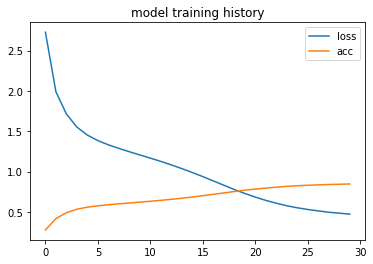

In [67]:
import pandas as pd
from matplotlib import pyplot as plt

pd.DataFrame(history.history).plot(title="model training history")
plt.show()

### Generating text
The simplest way to generate text with this model is to run it in a loop, and keep track of the model's internal state as we execute it.

![img](https://www.tensorflow.org/text/tutorials/images/text_generation_sampling.png)

Each time you call the model you pass in some text and an internal state. The model returns a prediction for the next character and its new state. Pass the prediction and state back in to continue generating text.

The following makes a single step prediction:


In [68]:
class OneStep(keras.Model):
  def __init__(self,
               model,
               chars_from_ids, 
               ids_from_chars,
               temperature=1.0
               ):
    super(OneStep, self).__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    ## Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]

    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())]
    )
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)
  
  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states


In [69]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

Let's run it in a loop to generate some text. Looking at the generated text, we'll see the model knows when to capitalize, make paragraphs and imitates a Shakespeare-like writing vocabulary. With the small number of training epochs, it has not yet learned to form coherent sentences.

In [71]:
start = time.time()
states = None
next_char = tf.constant(['VOLUMNIA:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)


VOLUMNIA:
I would thou hear's.

YORK:
I thank you, gentlemen, what say'st
thou, and by me with your servant?

VINCENTIO:
Carrior, let us see't.

FROTH:
Be petition; yea, and me, better, Biondello,
But did return for my son Lucentio his
wandering and-dance. Where Merbridou
Must help them, and not to question; you
will not be aged banish'd. Let him be grain'd:
Therefore be made and herbson that was much, in piercing steps,
Be telling of thy long-seding arms: her face,
Came to the bill that way home to thee;
But what o' that?

FLORIZEL:
And he, my soul seen had my father's son:
Peace, I have set my life and like to do
this thichey and the wheeling of that. Who's thee,
Very fool.

Second Henry:
Be pit on 't: then, I say, I come:
And now forthwith never were as fair and loat,
'Twixt six and now believe them.'
But what learning is the tempest there?

LADY ANNE:
I hope, shall stop what you most along;
Our general homes gone,
And had her noble house; why Hast thou move our
extermaid to England

To improve the model perfomance we may want to train for more epochs. Adding new layers, Maybe try to use LSTM.

If we want the model to generate text faster the easiest thing we can do is batch the text generation. In the example below the model generates 5 outputs in about the same time it took to generate 1 above.

In [74]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()

for res in result:
  print(res.numpy().decode('utf-8'))

print('\n\n' + '_'*80)
print('\nRun time:', end - start)


ROMEO:
My lord, I make a surpate none of your cousin
Men drudge alas, alarums! Who's there, ho?

VINCENTIO:
But what's his transfor natures?

CORIOLANUS:
My guilt be done! Then, as I am inward.

BIANCA:
And live, my lord,
We shall be mercy, and I enter'd in my
tomend on' that hath made a shame.

ANGELO:
Well; the very risor of your adversary
As you the man that have my woes told;
You that my heart as I. Ajove are you in words?

GREMIO:
But freeder,
That, by ghass fly to his mouth, 'shall,
And, for thou forgest what I be still and make him
do what I wish for Rome! the prince your father
To make a hurdy Kater his easily's royal,
And grans many axe until we thought these fairest chairful seas:
What I have said, Brakening battle strive,
In this o' the Aufiance in the malmsey'd
With heaven unwilling tongue.

SLY:
Welcome, Kate; for I have put meet be.

PETRUCHIO:
Be patient. What's the matter,
The life to close a sisterhood of his.

KATHARINA:
Minion tapest in thy honey would
I were a quart

### Export the generator model.
This single-step model can easily be saved and restored, allowing you to use it anywhere a `tf.saved_model` is accepted.

In [75]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: one_step/assets


INFO:tensorflow:Assets written to: one_step/assets


### Testing the saved model

In [76]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))


ROMEO:
There is no grain as prestrable to my soul.
Go, fall another, I must have stain'd with rebits
And i


### Advanced Custom training

The above training procedure is simple, but does not give we much control. It uses teacher-forcing which prevents bad predictions from being fed back to the model, so the model never learns to recover from mistakes.

So now that we've seen how to run the model manually next we'll implement the training loop. This gives a starting point if, for example, we want to implement curriculum learning to help stabilize the model's open-loop output.

The most important part of a custom training loop is the train step function.

Use `tf.GradientTape` to track the gradients. we can learn more about this approach by reading the eager execution guide.

The basic procedure is:

Execute the model and calculate the loss under a `tf.GradientTape`.
Calculate the updates and apply them to the model using the optimizer.
The basic procedure is:

* Execute the model and calculate the loss under a `tf.GradientTape`.
* Calculate the updates and apply them to the model using the optimizer

In [78]:
class CustomTraining(Model):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

The above implementation of the `train_step` method follows Keras' `train_step` conventions. This is optional, but it allows you to change the behavior of the train step and still use keras' Model.compile and `Model.fit` methods.

In [79]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [80]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))



In [81]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 27s 136ms/step - loss: 2.7101


Or if you need more control, you can write your own complete custom training loop:

In [ ]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))


### Credits
* [this tutorial](https://www.tensorflow.org/text/tutorials/text_generation)
* [tensorflow docs](https://www.tensorflow.org/api_docs/)